## Import Modules

In [23]:
# Image and video processing
import cv2
import mediapipe as mp

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns  

# Data handling and utilities
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
import random
from pathlib import Path
import pickle
import zipfile

# Machine learning (XGBoost)
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC

# TensorFlow and Keras (for CNNs)
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, MaxPooling2D, SeparableConv2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

In [24]:
# Check if TensorFlow is using a GPU
if tf.config.list_physical_devices('GPU'):
    print("TensorFlow is using the GPU.")
else:
    print("TensorFlow is not using the GPU.")


TensorFlow is using the GPU.


## Set Paramaters

In [25]:
letters = [
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 
    'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'
]

letters_dict_mnist = {
    0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H',
    8: 'I', 9: 'K', 10: 'L', 11: 'M', 12: 'N', 13: 'O', 14: 'P',
    15: 'Q', 16: 'R', 17: 'S', 18: 'T', 19: 'U', 20: 'V', 21: 'W', 22: 'X',
    23: 'Y', 
}

letters_dict_asl = {
    0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H',
    8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P',
    16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X',
    24: 'Y', 25: 'Z'
}

# Get the current working directory 
base_dir = Path().resolve()  

## Unzip the Data

In [26]:
def unzip_file(zip_file_path, extract_to_directory):
    # Ensure the extraction directory exists
    os.makedirs(extract_to_directory, exist_ok=True)
    
    # Open the zip file in read mode
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # Extract all the contents to the specified directory
        zip_ref.extractall(extract_to_directory)
    
    print(f"Unzipped {zip_file_path} to {extract_to_directory}")

In [27]:
# Get the mnist Data
# Define the folder path for the data
data_folder_path = base_dir / 'data'

# Define the path for the MNIST test data folder
mnist_path = Path(data_folder_path) / 'sign_mnist_test'

# Check if the folder exists
if mnist_path.is_dir():
    print('folder already exists')
    pass  
else:
    # If the folder does not exist, unzip the file
    zip_file = data_folder_path / 'sign_mnist.zip'
    extract_dir = data_folder_path
    
    # Assuming unzip_file is a defined function that extracts the zip file
    unzip_file(zip_file, extract_dir)

folder already exists


In [28]:
# Get the ASL Data
# Define the path for the MNIST test data folder
asl_path = Path(data_folder_path) / 'asl_alphabet_train'

# Check if the folder exists
if asl_path.is_dir():
    print('folder already exists')
    pass  
else:
    # If the folder does not exist, unzip the file
    zip_file = data_folder_path / 'asl.zip'
    extract_dir = data_folder_path
    
    # Assuming unzip_file is a defined function that extracts the zip file
    unzip_file(zip_file, extract_dir)

folder already exists


## MNIST

In [29]:
# Define paths relative to the base directory
train_path = base_dir / 'data' / 'sign_mnist_train' / 'sign_mnist_train.csv'
test_path = base_dir / 'data' / 'sign_mnist_test' / 'sign_mnist_test.csv'

# Get the train and test Data
df_mnist_train = pd.read_csv(train_path)
df_mnist_test = pd.read_csv(test_path)

### EDA

In [30]:
df_mnist_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [31]:
df_mnist_train.shape

(27455, 785)

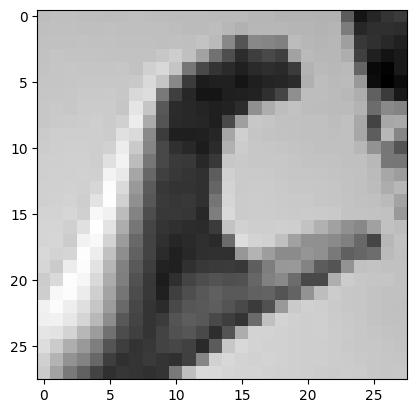

In [32]:
# See what one image would look like
hand_1 = np.array(df_mnist_train.iloc[2,1:]).reshape(28,28)
plt.imshow(hand_1, cmap='gray')

### Feature Creation

### Split the Data

In [33]:
# Make the train set
X_df_mnist_train = df_mnist_train.iloc[:,1:]
y_df_mnist_train = df_mnist_train.iloc[:,0]

# Make the test set
X_df_mnist_test = df_mnist_test.iloc[:,1:]
y_df_mnist_test = df_mnist_test.iloc[:,0]

# Encode the labels
le = LabelEncoder()
y_df_mnist_train_xgb = le.fit_transform(y_df_mnist_train)
y_df_mnist_test_xgb = le.transform(y_df_mnist_test)

### Train an Xgboost model

In [34]:
# Define the file name for the model
model_filename = base_dir / 'models' / 'xgboost_model_mnist.pkl'

# Check if the model file exists
model_file = Path(model_filename)

if model_file.is_file():
    # If the model exists, load it
    with open(model_filename, 'rb') as f:
        xgb_model_mnist = pickle.load(f)
    print("Model loaded")
else:
    # If the model does not exist, train it
    print("Model does not exist. Training a new model...")

    # Initialize and train the model
    xgb_model_mnist = xgb.XGBClassifier(tree_method="hist", device="cuda")
    xgb_model_mnist.fit(X_df_mnist_train, y_df_mnist_train_xgb)

    # Save the model after training
    with open(model_filename, 'wb') as f:
        pickle.dump(xgb_model_mnist, f)
    print(f"Model saved as {model_filename}")

# Make predictions
xgb_model_mnist.set_params(device="cuda")
y_preds = xgb_model_mnist.predict(X_df_mnist_test)

# Calculate accuracy
accuracy = accuracy_score(y_df_mnist_test_xgb, y_preds)
accuracy

Model loaded


c:\Users\user\anaconda3\envs\sign\lib\site-packages\xgboost\core.py:158: UserWarning: [19:42:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


0.7699386503067485

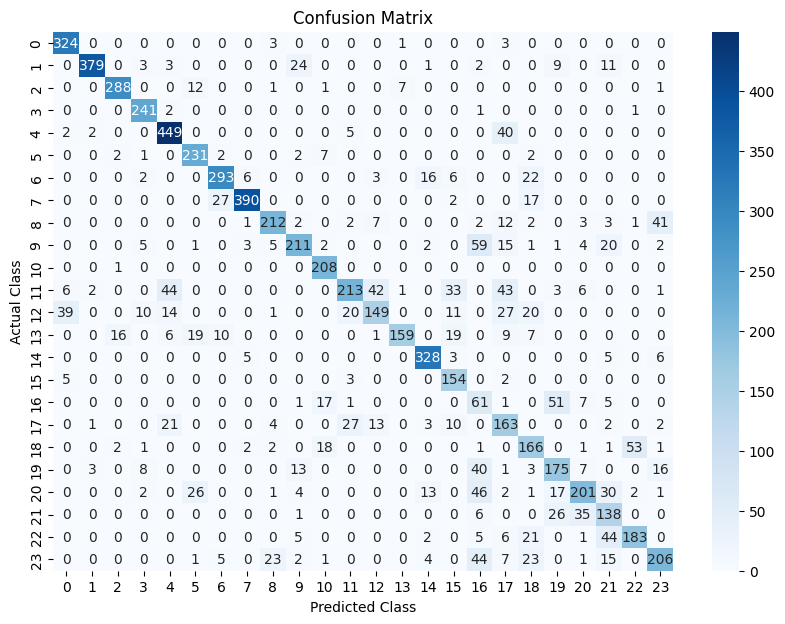

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.98      0.92       331
           1       0.98      0.88      0.93       432
           2       0.93      0.93      0.93       310
           3       0.88      0.98      0.93       245
           4       0.83      0.90      0.87       498
           5       0.80      0.94      0.86       247
           6       0.87      0.84      0.86       348
           7       0.96      0.89      0.93       436
           8       0.84      0.74      0.79       288
           9       0.80      0.64      0.71       331
          10       0.82      1.00      0.90       209
          11       0.79      0.54      0.64       394
          12       0.69      0.51      0.59       291
          13       0.95      0.65      0.77       246
          14       0.89      0.95      0.92       347
          15       0.65      0.94      0.77       164
          16       0.23      0.42      0.30       144
   

In [35]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_df_mnist_test_xgb, y_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

# Classification Report
class_report = classification_report(y_df_mnist_test_xgb, y_preds)
print("Classification Report:\n", class_report)

### CNN model

In [36]:
# Normalize the data
X_df_mnist_train_norm = X_df_mnist_train / 255
X_df_mnist_test_norm = X_df_mnist_test / 255

## CNN model
X_df_mnist_train_reshape = np.array(X_df_mnist_train_norm).reshape(-1, 28, 28, 1)
X_df_mnist_test_reshape = np.array(X_df_mnist_test_norm).reshape(-1, 28, 28, 1)

## Ensure y_df_mnist_train and y_df_mnist_test are one-hot encoded
y_df_mnist_train_cnn = to_categorical(y_df_mnist_train) 
y_df_mnist_test_cnn = to_categorical(y_df_mnist_test)

In [37]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)
datagen.fit(X_df_mnist_train_reshape)

# Learning rate reduction callback
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy', 
    patience=2, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001
)

In [38]:
# Define the file name for the model
model_filename = base_dir / 'models' / 'cnn_model_mnist.h5'

# Check if the model file exists
model_file = Path(model_filename)

# Check if the model exists
if model_filename.is_file():
    # If the model exists, load it
    cnn_model = load_model(model_filename)
    print("Model loaded")
else:
    # If the model does not exist, build and train the CNN model
    print("Model does not exist. Training a new model...")

    # Build the CNN model
    cnn_model = Sequential()

    # First convolutional block
    cnn_model.add(Conv2D(64, (5, 5), strides=1, padding='same', activation='relu', input_shape=(28, 28, 1)))
    cnn_model.add(BatchNormalization())
    cnn_model.add(MaxPooling2D((2, 2), strides=2))

    # Second convolutional block with SeparableConv2D
    cnn_model.add(SeparableConv2D(128, (3, 3), strides=1, padding='same', activation='relu'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(MaxPooling2D((2, 2), strides=2))

    # Third convolutional block with SeparableConv2D
    cnn_model.add(SeparableConv2D(256, (3, 3), strides=1, padding='same', activation='relu'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(MaxPooling2D((2, 2), strides=2))

    # Fourth convolutional block
    cnn_model.add(Conv2D(512, (3, 3), strides=1, padding='same', activation='relu'))
    cnn_model.add(BatchNormalization())

    # Flatten and fully connected layers
    cnn_model.add(Flatten())
    cnn_model.add(Dense(512, activation='relu'))
    cnn_model.add(Dropout(0.4))  # Dropout for regularization

    # Output layer (assuming 25 classes)
    cnn_model.add(Dense(25, activation='softmax'))

    # Compile the model
    cnn_model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Now you need to train the model (make sure you have your training data)
    # Train the model
    history = cnn_model.fit(
        datagen.flow(X_df_mnist_train_reshape, y_df_mnist_train_cnn, batch_size=128),
        epochs=20,
        validation_data=(X_df_mnist_test_reshape, y_df_mnist_test_cnn),
        callbacks=[learning_rate_reduction]
    )

    # After training, save the model
    cnn_model.save(model_filename)
    print("Model trained and saved")

Model loaded


In [39]:
# Evaluate the model
test_loss, test_accuracy = cnn_model.evaluate(X_df_mnist_test_reshape, y_df_mnist_test_cnn)
print(f"Test accuracy: {test_accuracy}")

225/225 [==============================] - 8s 4ms/step - loss: 7.7256e-05 - accuracy: 1.0000
Test accuracy: 1.0


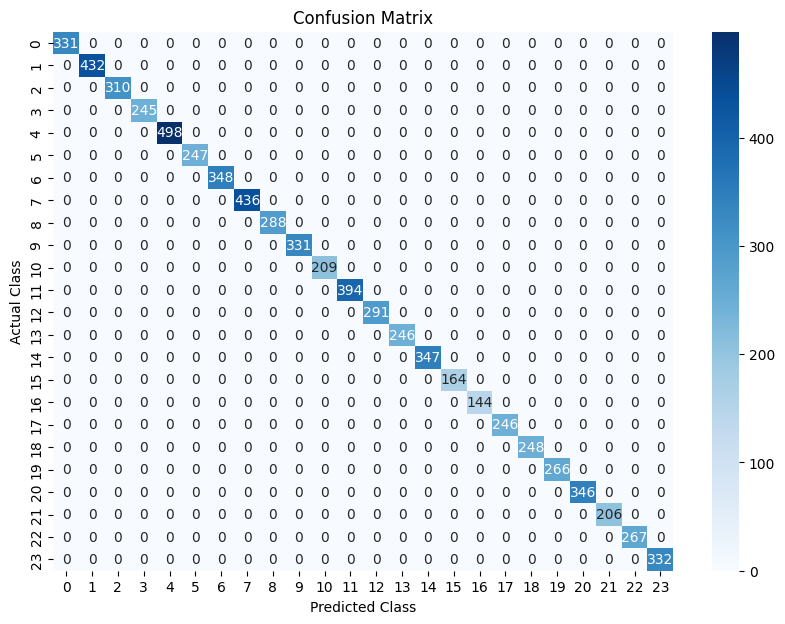

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       331
           1       1.00      1.00      1.00       432
           2       1.00      1.00      1.00       310
           3       1.00      1.00      1.00       245
           4       1.00      1.00      1.00       498
           5       1.00      1.00      1.00       247
           6       1.00      1.00      1.00       348
           7       1.00      1.00      1.00       436
           8       1.00      1.00      1.00       288
          10       1.00      1.00      1.00       331
          11       1.00      1.00      1.00       209
          12       1.00      1.00      1.00       394
          13       1.00      1.00      1.00       291
          14       1.00      1.00      1.00       246
          15       1.00      1.00      1.00       347
          16       1.00      1.00      1.00       164
          17       1.00      1.00      1.00       144
   

In [40]:
# Make predictions (cnn_model.predict returns probabilities, so we need to convert them to class labels)
y_preds_cnn = cnn_model.predict(X_df_mnist_test_reshape)

# Convert probabilities to predicted class labels
y_preds_cnn_classes = np.argmax(y_preds_cnn, axis=1)

# Convert true labels to integer class labels if they are one-hot encoded
# Assuming y_df_mnist_test_cnn is one-hot encoded, otherwise skip this
if len(y_df_mnist_test_cnn.shape) > 1:
    y_df_mnist_test_cnn_classes = np.argmax(y_df_mnist_test_cnn, axis=1)
else:
    y_df_mnist_test_cnn_classes = y_df_mnist_test_cnn

# Confusion Matrix
conf_matrix = confusion_matrix(y_df_mnist_test_cnn_classes, y_preds_cnn_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

# Classification Report
class_report = classification_report(y_df_mnist_test_cnn_classes, y_preds_cnn_classes)
print("Classification Report:\n", class_report)

In [41]:
np.unique(y_preds_cnn_classes)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24], dtype=int64)

In [42]:
# Predict for a single test image
single_image = np.expand_dims(X_df_mnist_test_reshape[0], axis=0)

# Perform the prediction
prediction = cnn_model.predict(single_image)

# Print the prediction (class probabilities)
print(prediction)

# If you want to get the class with the highest probability:
predicted_class = np.argmax(prediction, axis=1)
print(f"Predicted class: {predicted_class[0]}")

[[1.6757503e-17 2.4722671e-16 3.7667407e-15 1.3186367e-18 1.7094926e-17
  3.3500277e-16 1.0000000e+00 1.1027584e-11 1.2877557e-19 5.8265543e-20
  5.0565286e-18 2.9236520e-16 1.1050700e-19 1.0805021e-17 2.9957001e-14
  3.4788165e-16 1.4871556e-16 5.9003233e-19 1.0771029e-17 1.1109395e-14
  1.2821370e-21 4.3995856e-22 5.1380897e-21 8.0288651e-13 5.9873670e-19]]
Predicted class: 6


### Make Live Predictions

In [43]:
def run_trained_model(selected_model):
    # Initialize MediaPipe Hands
    mp_hands = mp.solutions.hands

    # Set up the MediaPipe Hands model
    hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5, min_tracking_confidence=0.5)

    # Open the video file or capture from webcam
    video_capture = cv2.VideoCapture(0)  # Replace with your video file path or use 0 for webcam

    # Output directory to save the cropped hand image
    output_dir = 'hand_images'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    frame_counter = 0  # To keep track of the frame number

    while True:
        success, frame = video_capture.read()
        
        if not success:
            print("End of video or cannot read the frame.")
            break
        
        # Convert the frame to RGB (MediaPipe expects RGB images)
        img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Process the frame for hand tracking
        result = hands.process(img_rgb)

        prediction_text = ""

        # If hands are detected, crop and save the hand
        if result.multi_hand_landmarks:
            for hand_landmarks in result.multi_hand_landmarks:
                # Get the image dimensions
                h, w, c = frame.shape
                
                # Calculate the bounding box for the hand
                x_min = w
                y_min = h
                x_max = 0
                y_max = 0
                
                # Iterate through the hand landmarks to get the bounding box
                for lm in hand_landmarks.landmark:
                    x, y = int(lm.x * w), int(lm.y * h)
                    if x < x_min: x_min = x
                    if y < y_min: y_min = y
                    if x > x_max: x_max = x
                    if y > y_max: y_max = y

                # Add some padding to the bounding box
                padding = 10
                x_min = max(0, x_min - padding)
                y_min = max(0, y_min - padding)
                x_max = min(w, x_max + padding)
                y_max = min(h, y_max + padding)

                # Crop the hand region from the frame
                cropped_hand = frame[y_min:y_max, x_min:x_max]
                
                # Resize the cropped hand to 28x28 pixels (for prediction)
                if cropped_hand.size > 0:
                    img_hand_resized = cv2.resize(cropped_hand, (28, 28))

                    # Convert the resized hand to grayscale
                    gray_image = cv2.cvtColor(img_hand_resized, cv2.COLOR_BGR2GRAY)

                    # Perform the prediction
                    if selected_model == 'cnn':

                        # Normalize and expand dimensions to match the model's expected input shape
                        gray_image = gray_image.astype('float32') / 255.0  
                        gray_image = np.expand_dims(gray_image, axis=-1)  
                        gray_image = np.expand_dims(gray_image, axis=0)  
                        
                        # Make the prediction
                        prediction = cnn_model.predict(gray_image)

                        # If you want to get the class with the highest probability:
                        predicted_class = np.argmax(prediction, axis=1)  # Assuming prediction is 2D, else remove axis=1

                        # Transform the predicted class using the label encoder (le)
                        predicted_class_trans = le.transform([predicted_class[0]])[0]  # Apply transform to an array-like input and get the first element

                        # Store the prediction text to display on the frame
                        prediction_text = f'Predicted Label: {letters_dict_mnist[predicted_class_trans]}'
                    
                    elif selected_model == 'boost':
                        gray_image_flattened = gray_image.ravel().reshape(1, -1)

                        # Perform the prediction with the XGBoost model
                        prediction = xgb_model_mnist.predict(gray_image_flattened)

                        # Store the prediction text to display on the frame
                        prediction_text = f'Predicted Label: {letters_dict_mnist[prediction[0]]}'


        # Display the prediction on the frame
        if prediction_text:
            cv2.putText(frame, prediction_text, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

        # Show the video with prediction in a window
        cv2.imshow("Hand Gesture Recognition", frame)

        # Exit loop when 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release the video capture and destroy all windowsq
    video_capture.release()
    cv2.destroyAllWindows()

In [44]:
# Select which model you would like to predict with
# run_trained_model('boost')
run_trained_model('cnn')

## 21 points

### EDA

Sample images for letter A


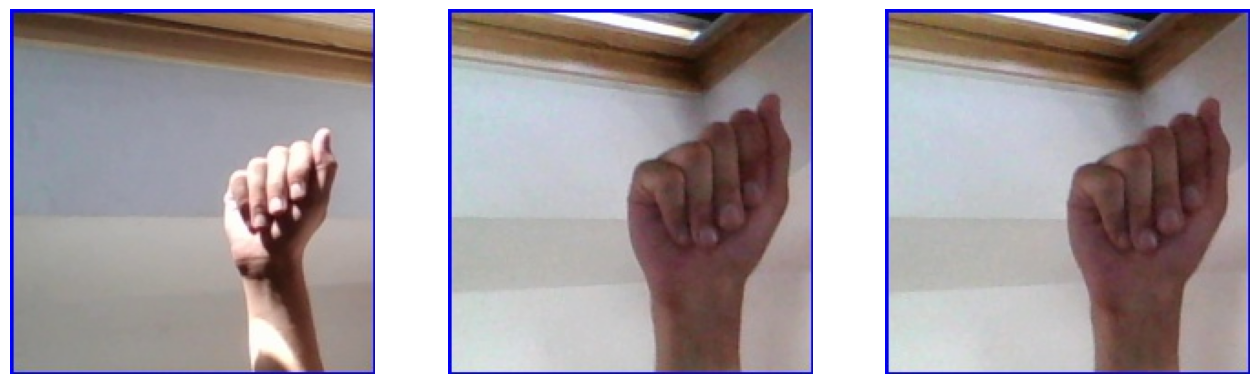

In [51]:
def plot_three_samples(letter):
    print("Sample images for letter " + letter)

    # Define the path to the subfolder for the given letter
    img_folder = base_dir / 'data' / 'asl_alphabet_train' / 'asl_alphabet_train' / letter
    
    # Search for all images inside the letter's folder
    img_path = str(img_folder / '*.jpg')  # Search for all .jpg files in the letter folder
    
    # Get all image paths for the given letter using glob
    path_contents = sorted(glob(img_path))  # Sort the images for consistent order
    
    if len(path_contents) < 3:
        print(f"Not enough images found for letter {letter}. Found {len(path_contents)} images.")
        return
    
    # Select the first 3 images from the available images
    imgs = path_contents[3:6]
    
    # Display the images
    plt.figure(figsize=(16, 16))
    
    for i in range(3):  # Loop to display 3 images
        img = cv2.imread(imgs[i])
        if img is None:
            print(f"Could not read image {imgs[i]}")
            continue
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for plotting
        plt.subplot(1, 3, i+1)
        plt.imshow(img_rgb)
        plt.axis('off')  # Hide the axes for cleaner output
    
    plt.show()

    return img

# Example call to plot the first three samples for letter 'A'
img_letter = plot_three_samples('A')

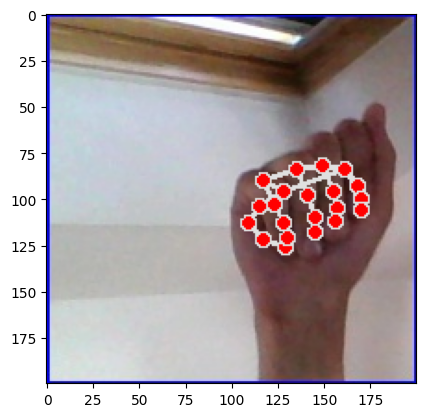

In [52]:
# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
mp_draw = mp.solutions.drawing_utils

# Set up the MediaPipe Hands model
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5, min_tracking_confidence=0.5)

# Assume `img_letter` is your input image in RGB format
frame = img_letter  # Your RGB image

# Process the frame for hand tracking (no need for color conversion, it's already in RGB)
result = hands.process(frame)

# If hands are detected, draw landmarks and connections
if result.multi_hand_landmarks:
    for hand_landmarks in result.multi_hand_landmarks:
        # Draw the landmarks on the original frame
        mp_draw.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

# Convert the frame back to BGR for display with OpenCV
frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

# Display the frame with hand tracking
plt.imshow(frame_bgr)

### Feature Creation Without Image Augemntation

In [53]:
# Define the path for the Parquet file
parquet_path = base_dir / 'data' / 'asl_21_features.parquet'

# Check if the Parquet file already exists
if parquet_path.exists():
    print(f"Loading existing Parquet file")
    df_asl_21 = pd.read_parquet(parquet_path)

else:
    lst_lst = []
    for letter in letters:
        # Construct the path to the images for the given letter (relative to base_dir)
        img_folder = base_dir / 'data' / 'asl_alphabet_train' / 'asl_alphabet_train' / letter
        img_path = str(img_folder / '*.jpg')

        # Initialize MediaPipe Hands
        mp_hands = mp.solutions.hands
        mp_draw = mp.solutions.drawing_utils

        # Set up the MediaPipe Hands model
        hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.5, min_tracking_confidence=0.5)

        # Get all image paths for the given letter
        path_contents = glob(img_path)

        for img_path in tqdm(path_contents):
            # print(f'Processing: {img_path}')
            img = cv2.imread(img_path)

            # Convert the image from BGR (OpenCV format) to RGB (required by MediaPipe)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Process the image for hand tracking
            result = hands.process(img_rgb)

            # Check if hand landmarks were detected
            if result.multi_hand_landmarks:
                for hand_landmarks in result.multi_hand_landmarks:
                    # Flatten the x, y, z coordinates of the landmarks
                    flattened_list = [value for landmark in hand_landmarks.landmark for value in (landmark.x, landmark.y, landmark.z)]
                    # Append the letter
                    flattened_list.append(letter)
                    # Add to the final list
                    lst_lst.append(flattened_list)
            else:
                # print(f'No hand landmarks detected in: {img_path}')
                pass
    # Convert lst_lst to a DataFrame
    df_asl_21 = pd.DataFrame(lst_lst, columns=[f'feature_{i}' for i in range(63)] + ['label'])

    # Save the DataFrame to Parquet
    df_asl_21.to_parquet(parquet_path)
    print(f"Data saved to Parquet file: {parquet_path}")

Loading existing Parquet file


### Feature Creation With Image Augmentation

In [54]:
# Define the path for the Parquet file
parquet_path = base_dir / 'data' / 'asl_21_features_aug.parquet'

# Check if the Parquet file already exists
if parquet_path.exists():
    print(f"Loading existing Parquet file: {parquet_path}")
    df_asl_21_aug = pd.read_parquet(parquet_path)

else:

    # Initialize MediaPipe Hands
    mp_hands = mp.solutions.hands
    mp_draw = mp.solutions.drawing_utils

    # Set up the MediaPipe Hands model
    hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.5, min_tracking_confidence=0.5)

    # ImageDataGenerator for augmentation
    datagen = ImageDataGenerator(
        rotation_range=20,      # Rotate images by up to 20 degrees
        width_shift_range=0.2,  # Shift the image horizontally by 20%
        height_shift_range=0.2, # Shift the image vertically by 20%
        shear_range=0.15,       # Apply shear transformations
        zoom_range=0.2,         # Apply zoom transformations
        horizontal_flip=True,   # Flip the image horizontally
        fill_mode='nearest',    # Fill in missing pixels after transformation
        brightness_range=[0.8, 1.2]  # Adjust brightness (0.8 = darker, 1.2 = brighter)
    )

    # List to store the original and augmented images with hand landmark data
    lst_lst = []

    # Process each letter
    for letter in letters:
        # Construct the path to the images for the given letter (relative to base_dir)
        img_folder = base_dir / 'data' / 'asl_unzipped' / 'asl_alphabet_train' / 'asl_alphabet_train' / letter
        img_path = str(img_folder / '*.jpg')

        # First, process the original images
        for img_path in tqdm(path_contents):
            # Load the image using OpenCV
            img = cv2.imread(img_path)

            # Convert the image from BGR (OpenCV format) to RGB (required by MediaPipe)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # plt.imshow(img_rgb)
            # plt.show()
            # Process the original image with MediaPipe
            result = hands.process(img_rgb)

            # Check if hand landmarks were detected
            if result.multi_hand_landmarks:
                for hand_landmarks in result.multi_hand_landmarks:
                    # Flatten the x, y, z coordinates of the landmarks
                    flattened_list = [value for landmark in hand_landmarks.landmark for value in (landmark.x, landmark.y, landmark.z)]
                    # Append the letter as the label
                    flattened_list.append(letter)
                    # Add the original image's landmarks to the final list
                    lst_lst.append(flattened_list)

            # Reshape the image for ImageDataGenerator (batch of 1 image)
            img_array = np.expand_dims(img_rgb, axis=0)

            # Generate augmented images using ImageDataGenerator
            aug_iter = datagen.flow(img_array, batch_size=1)

            # Create 5 augmented images for each original image
            for i in range(5):
                # Get the next augmented image
                aug_img = next(aug_iter)[0].astype(np.uint8)  # Convert the image back to uint8
                # plt.imshow(aug_img)
                # plt.show()
                # Process the augmented image with MediaPipe to get hand landmarks
                result = hands.process(aug_img)

                # Check if hand landmarks were detected
                if result.multi_hand_landmarks:
                    for hand_landmarks in result.multi_hand_landmarks:
                        # Flatten the x, y, z coordinates of the landmarks
                        flattened_list = [value for landmark in hand_landmarks.landmark for value in (landmark.x, landmark.y, landmark.z)]
                        # Append the letter as the label
                        flattened_list.append(letter)
                        # Add the augmented image's landmarks to the final list
                        lst_lst.append(flattened_list)

    # Convert lst_lst to a DataFrame
    df = pd.DataFrame(lst_lst, columns=[f'feature_{i}' for i in range(63)] + ['label'])
    # Ensure all column names are strings
    df.columns = df.columns.map(str)
    # Save the DataFrame to Parquet
    df.to_parquet(parquet_path)
    print(f"Data saved to Parquet file: {parquet_path}")

Loading existing Parquet file: C:\Users\user\OneDrive\Desktop\trial_notebooks\facial_recognition\data\asl_21_features_aug.parquet


### Train asl model

In [55]:
# Extract features and labels
X_asl = df_asl_21.iloc[:, :-1]  
y_asl = df_asl_21.iloc[:, -1]   

# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit and transform the labels into numeric form
y_aug = label_encoder.fit_transform(y_asl)

#### Train xgboost model

In [57]:
# Define the file name for the model
model_filename = base_dir / 'models' / 'xgboost_model_21.pkl'

# Check if the model file exists
model_file = Path(model_filename)

if model_file.is_file():
    # If the model exists, load it
    with open(model_filename, 'rb') as f:
        xgb_model_21 = pickle.load(f)
    print("Model loaded")
else:
    # Train XGBoost model
    xgb_model_21 = xgb.XGBClassifier(tree_method="hist", device="cuda")

    # Fit the model
    xgb_model_21.fit(X_asl, y_asl)

        # Save the model after training
    with open(model_filename, 'wb') as f:
        pickle.dump(xgb_model_21, f)
    print("Model saved")

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25], got ['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R'
 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z']

#### FFNN

In [58]:
# Define the base directory and model file path (ensure base_dir is defined elsewhere)
model_filename = base_dir / 'models' / 'nn_model_21.h5'

# Check if the model file exists
if model_filename.is_file():
    # Convert Path object to string for load_model function
    nn_model_21 = load_model(str(model_filename))
    print("Model loaded")
else:

    # Number of input features 
    input_dim = X_asl.shape[1]  #

    # Number of classes (letters A-Z + "nothing", "space", "del")
    num_classes = len(set(y_asl))  

    # Neural network architecture
    nn_model_21 = Sequential()

    # Input layer and first hidden layer with 128 neurons and ReLU activation
    nn_model_21.add(Dense(128, input_dim=input_dim, activation='relu'))

    # Optional: Add dropout to prevent overfitting
    nn_model_21.add(Dropout(0.3))

    # Second hidden layer with 64 neurons and ReLU activation
    nn_model_21.add(Dense(64, activation='relu'))

    # Optional: Add another dropout layer
    nn_model_21.add(Dropout(0.3))

    # Output layer with 'num_classes' neurons (one for each letter) and softmax activation
    nn_model_21.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    nn_model_21.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = nn_model_21.fit(X_asl, y_asl, epochs=20, batch_size=32, validation_split=0.2)
    nn_model_21.save(str(model_filename))
    print('Model Saved')

Epoch 1/20


UnimplementedError:  Cast string to int64 is not supported
	 [[node sparse_categorical_crossentropy/Cast
 (defined at c:\Users\user\anaconda3\envs\sign\lib\site-packages\keras\backend.py:1977)
]] [Op:__inference_train_function_8225]

Errors may have originated from an input operation.
Input Source operations connected to node sparse_categorical_crossentropy/Cast:
In[0] IteratorGetNext (defined at c:\Users\user\anaconda3\envs\sign\lib\site-packages\keras\engine\training.py:866)

Operation defined at: (most recent call last)
>>>   File "c:\Users\user\anaconda3\envs\sign\lib\runpy.py", line 197, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "c:\Users\user\anaconda3\envs\sign\lib\runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "C:\Users\user\AppData\Roaming\Python\Python39\site-packages\ipykernel_launcher.py", line 18, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "C:\Users\user\AppData\Roaming\Python\Python39\site-packages\traitlets\config\application.py", line 1075, in launch_instance
>>>     app.start()
>>> 
>>>   File "C:\Users\user\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelapp.py", line 739, in start
>>>     self.io_loop.start()
>>> 
>>>   File "C:\Users\user\AppData\Roaming\Python\Python39\site-packages\tornado\platform\asyncio.py", line 205, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "c:\Users\user\anaconda3\envs\sign\lib\asyncio\base_events.py", line 601, in run_forever
>>>     self._run_once()
>>> 
>>>   File "c:\Users\user\anaconda3\envs\sign\lib\asyncio\base_events.py", line 1905, in _run_once
>>>     handle._run()
>>> 
>>>   File "c:\Users\user\anaconda3\envs\sign\lib\asyncio\events.py", line 80, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "C:\Users\user\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "C:\Users\user\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 534, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "C:\Users\user\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
>>>     await result
>>> 
>>>   File "C:\Users\user\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
>>>     await super().execute_request(stream, ident, parent)
>>> 
>>>   File "C:\Users\user\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "C:\Users\user\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
>>>     res = shell.run_cell(
>>> 
>>>   File "C:\Users\user\AppData\Roaming\Python\Python39\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
>>>     return super().run_cell(*args, **kwargs)
>>> 
>>>   File "C:\Users\user\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3048, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "C:\Users\user\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3103, in _run_cell
>>>     result = runner(coro)
>>> 
>>>   File "C:\Users\user\AppData\Roaming\Python\Python39\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "C:\Users\user\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3308, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "C:\Users\user\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3490, in run_ast_nodes
>>>     if await self.run_code(code, result, async_=asy):
>>> 
>>>   File "C:\Users\user\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "C:\Users\user\AppData\Local\Temp\ipykernel_1428\522460974.py", line 39, in <module>
>>>     history = nn_model_21.fit(X_asl, y_asl, epochs=20, batch_size=32, validation_split=0.2)
>>> 
>>>   File "c:\Users\user\anaconda3\envs\sign\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "c:\Users\user\anaconda3\envs\sign\lib\site-packages\keras\engine\training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "c:\Users\user\anaconda3\envs\sign\lib\site-packages\keras\engine\training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "c:\Users\user\anaconda3\envs\sign\lib\site-packages\keras\engine\training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "c:\Users\user\anaconda3\envs\sign\lib\site-packages\keras\engine\training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "c:\Users\user\anaconda3\envs\sign\lib\site-packages\keras\engine\training.py", line 809, in train_step
>>>     loss = self.compiled_loss(
>>> 
>>>   File "c:\Users\user\anaconda3\envs\sign\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
>>>     loss_value = loss_obj(y_t, y_p, sample_weight=sw)
>>> 
>>>   File "c:\Users\user\anaconda3\envs\sign\lib\site-packages\keras\losses.py", line 141, in __call__
>>>     losses = call_fn(y_true, y_pred)
>>> 
>>>   File "c:\Users\user\anaconda3\envs\sign\lib\site-packages\keras\losses.py", line 245, in call
>>>     return ag_fn(y_true, y_pred, **self._fn_kwargs)
>>> 
>>>   File "c:\Users\user\anaconda3\envs\sign\lib\site-packages\keras\losses.py", line 1737, in sparse_categorical_crossentropy
>>>     return backend.sparse_categorical_crossentropy(
>>> 
>>>   File "c:\Users\user\anaconda3\envs\sign\lib\site-packages\keras\backend.py", line 5098, in sparse_categorical_crossentropy
>>>     target = cast(target, 'int64')
>>> 
>>>   File "c:\Users\user\anaconda3\envs\sign\lib\site-packages\keras\backend.py", line 1977, in cast
>>>     return tf.cast(x, dtype)
>>> 

### Training aug model

In [59]:
# Extract features and labels
X_aug = df_asl_21_aug.iloc[:, :-1]  
y_aug = df_asl_21_aug.iloc[:, -1]   

# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit and transform the labels into numeric form
y_aug = label_encoder.fit_transform(y_aug)

#### Xgboost Model

In [60]:
# Define the file name for the model
model_filename = base_dir / 'models' / 'xgboost_model_21_aug.pkl'

# Check if the model file exists
model_file = Path(model_filename)

if model_file.is_file():
    # If the model exists, load it
    with open(model_filename, 'rb') as f:
        xgb_model_21_aug = pickle.load(f)
    print("Model loaded")
else:
    # Train XGBoost model
    xgb_model_21_aug = xgb.XGBClassifier(tree_method="hist", device="cuda"  )

    # Fit the model
    xgb_model_21_aug.fit(X_aug, y_aug)

        # Save the model after training
    with open(model_filename, 'wb') as f:
        pickle.dump(xgb_model_21_aug, f)
    print("Model saved")

Model loaded


### FFNN

In [61]:
# Define the base directory and model file path (ensure base_dir is defined elsewhere)
model_filename = base_dir / 'models' / 'nn_model_21_aug.h5'

# Check if the model file exists
if model_filename.is_file():
    # Convert Path object to string for load_model function
    nn_model_21_aug = load_model(str(model_filename))
    print("Model loaded")
else:

    # Number of input features 
    input_dim = X_aug.shape[1]  #

    # Number of classes (letters A-Z + "nothing", "space", "del")
    num_classes = len(set(y_aug))  

    # Neural network architecture
    model = Sequential()

    # Input layer and first hidden layer with 128 neurons and ReLU activation
    model.add(Dense(128, input_dim=input_dim, activation='relu'))

    # Optional: Add dropout to prevent overfitting
    model.add(Dropout(0.3))

    # Second hidden layer with 64 neurons and ReLU activation
    model.add(Dense(64, activation='relu'))

    # Optional: Add another dropout layer
    model.add(Dropout(0.3))

    # Output layer with 'num_classes' neurons (one for each letter) and softmax activation
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_aug, y_aug, epochs=20, batch_size=32, validation_split=0.2)
    model.save(str(model_filename))
    print('Model Saved')

Model loaded


In [62]:
# Path to the test image
# Define the relative path to the image (relative to the base_dir)
letter_filename = base_dir / 'data' / 'asl_alphabet_test' / 'asl_alphabet_test' / 'G_test.jpg'

# Convert the Path object to a string and read the image using OpenCV
test_img = cv2.imread(str(letter_filename))

if test_img is None:
    print("Error: Could not read the image.")
else:
    print("Image loaded successfully.")

# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
mp_draw = mp.solutions.drawing_utils

# Set up the MediaPipe Hands model
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.5, min_tracking_confidence=0.5)

# Convert the image from BGR (OpenCV format) to RGB (required by MediaPipe)
img_rgb = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

# Process the image for hand tracking
result = hands.process(img_rgb)

flattened_list = None  # Initialize the flattened_list variable

# Check if hand landmarks were detected
if result.multi_hand_landmarks:
    for hand_landmarks in result.multi_hand_landmarks:
        # Flatten the x, y, z coordinates of the landmarks
        flattened_list = [value for landmark in hand_landmarks.landmark for value in (landmark.x, landmark.y, landmark.z)]
else:
    print("No hand landmarks detected")

# Output the flattened list of landmarks if detected
if flattened_list:
    print(flattened_list)
else:
    print("No hand landmarks to display")


Image loaded successfully.
[0.5890499353408813, 0.7318325638771057, -3.569548923110233e-08, 0.6319938898086548, 0.6309475302696228, -0.06882049888372421, 0.5880247950553894, 0.5029140710830688, -0.09294354170560837, 0.4948457181453705, 0.4460025429725647, -0.10980174690485, 0.4098379611968994, 0.42047542333602905, -0.12660640478134155, 0.427369087934494, 0.5087055563926697, -0.06310175359249115, 0.2981310486793518, 0.459886759519577, -0.11713755875825882, 0.20439578592777252, 0.43466898798942566, -0.15011878311634064, 0.13316786289215088, 0.4181952476501465, -0.17151589691638947, 0.3953929543495178, 0.5846620798110962, -0.055767208337783813, 0.32885870337486267, 0.5493793487548828, -0.1577189713716507, 0.42303094267845154, 0.6032735109329224, -0.18756519258022308, 0.5058295726776123, 0.6472511291503906, -0.18091192841529846, 0.37860107421875, 0.6588550806045532, -0.05457063019275665, 0.3276185095310211, 0.638831377029419, -0.15923023223876953, 0.42756932973861694, 0.6852941513061523, -

In [63]:
# Assuming the model was trained with the same number of features (63 in your case)
# and flattened_list is the list of 63 landmark coordinates (x, y, z for 21 landmarks)
if flattened_list:
    flattened_array = np.array(flattened_list).reshape(1, -1)  # Reshape to a 2D array (1 sample, n features)
    
    # Predict using the XGBoost model
    prediction = nn_model_21_aug.predict(flattened_array)
    
    print("Predicted class:", np.argmax(prediction,axis=1))
else:
    print("No landmarks to predict on.")

Predicted class: [6]


### Test with camera

In [64]:
def test_21_camera(selected_model, aug=True):
    # Initialize MediaPipe Hands
    mp_hands = mp.solutions.hands
    mp_draw = mp.solutions.drawing_utils

    # Set up the MediaPipe Hands model
    hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5, min_tracking_confidence=0.5)

    # Open the webcam
    cap = cv2.VideoCapture(0)

    if not cap.isOpened():
        print("Error: Could not open webcam.")
        exit()

    while True:
        ret, frame = cap.read()
        
        if not ret:
            print("Failed to grab frame.")
            break

        # Convert the frame to RGB as MediaPipe uses RGB images
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Process the frame for hand tracking
        result = hands.process(rgb_frame)

        # Initialize a variable to store the prediction
        prediction_text = ""

        # If hands are detected, draw landmarks and connections and make predictions
        if result.multi_hand_landmarks:
            for hand_landmarks in result.multi_hand_landmarks:
                # Draw the landmarks on the original frame
                mp_draw.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

                # Flatten the x, y, z coordinates of the landmarks
                flattened_list = [value for landmark in hand_landmarks.landmark for value in (landmark.x, landmark.y, landmark.z)]
                flattened_array = np.array(flattened_list).reshape(1, -1)  # Reshape for the model input

                if selected_model == 'nn':
                    if aug:
                        # Make a prediction using the NN model
                        prediction_nn = nn_model_21_aug.predict(flattened_array)  
                    else:
                        # Make a prediction using the NN model
                        prediction_nn = nn_model_21.predict(flattened_array)                         

                    # Convert the combined numeric prediction back to the letter using inverse_transform
                    numeric_prediction = np.argmax(prediction_nn)
                    proba = np.max(prediction_nn)  # Get the index of the max probability
                    predicted_letter = label_encoder.inverse_transform([numeric_prediction])[0]  # Decode the predicted letter

                    # Store the prediction
                    prediction_text = f'Predicted Letter: {predicted_letter},{round(proba/2,2)}'
                
                elif selected_model == 'xgb':
                    if aug:
                        # Make a prediction using the NN model
                        prediction_xgb = xgb_model_21_aug.predict_proba(flattened_array)  
                    else:
                        # Make a prediction using the NN model
                        prediction_xgb = xgb_model_21.predict_proba(flattened_array)                         

                    # Convert the combined numeric prediction back to the letter using inverse_transform
                    numeric_prediction = np.argmax(prediction_xgb)
                    proba = np.max(prediction_xgb)  # Get the index of the max probability
                    predicted_letter = label_encoder.inverse_transform([numeric_prediction])[0]  # Decode the predicted letter

                    # Store the prediction
                    prediction_text = f'Predicted Letter: {predicted_letter},{round(proba/2,2)}'

        # Display the prediction on the frame
        if prediction_text:
            cv2.putText(frame, prediction_text, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

        # Display the frame with hand tracking and prediction
        cv2.imshow("Hand Tracking and Prediction", frame)

        # Exit the loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release the capture and close OpenCV windows
    cap.release()
    cv2.destroyAllWindows()


In [65]:
# test_21_camera('nn', aug=True)
test_21_camera('xgb', aug=True)